In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [3]:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
val_dir = '/kaggle/input/intel-image-classification/seg_pred'

In [4]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [7]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

# Перевірка балансу класів у тренувальному наборі
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 6
Класи: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Розмір тренувального набору: 14034
Розмір валідаційного набору: 7301
Розмір тестового набору: 3000

Розподіл класів у тренувальному наборі:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [8]:
import time
import torch
import os
from torch import nn, optim
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader

# Додати списки для збереження значень втрат і точностей
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
num_epochs=4

# Assuming `train_loader` and `val_loader` are already defined
def train_model(model, criterion, optimizer, num_epochs=num_epochs, train_loader=None, test_loader=None):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Зберегти втрати та точності для тренування
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        test_loss = running_loss / len(test_loader.dataset)
        test_acc = running_corrects.double() / len(test_loader.dataset)

        # Зберегти втрати та точності для валідації
        test_losses.append(test_loss)
        test_accuracies.append(test_acc.item())

        print(f'Validation Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

        # Save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    return model


In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 6)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)

# Перенесення моделі на GPU, якщо доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


In [10]:
# Example of calling the function
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=num_epochs, train_loader=train_loader, test_loader=test_loader)

Epoch 1/4
----------
Training Loss: 0.6453 Acc: 0.7962
Validation Loss: 0.3038 Acc: 0.9023
Epoch 2/4
----------
Training Loss: 0.2691 Acc: 0.9125
Validation Loss: 0.2449 Acc: 0.9173
Epoch 3/4
----------
Training Loss: 0.1967 Acc: 0.9354
Validation Loss: 0.2239 Acc: 0.9233
Epoch 4/4
----------
Training Loss: 0.1517 Acc: 0.9520
Validation Loss: 0.2187 Acc: 0.9233
Training complete in 3m 37s
Best val Acc: 0.9233


Accuracy: 0.9233
F1 Score: 0.9231


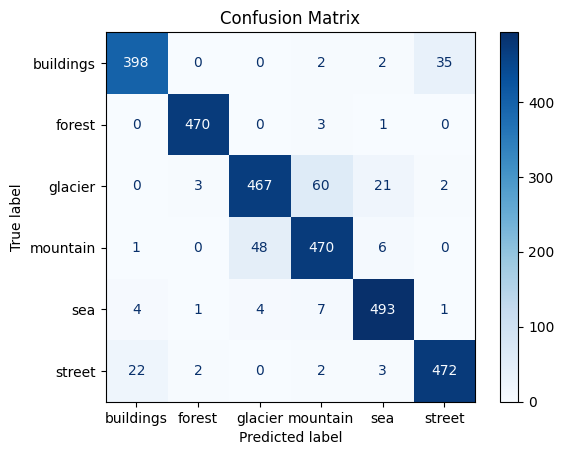

In [11]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()  # Переключити модель у режим оцінювання
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Без обчислення градієнтів
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Обчислення точності та F1-міри
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # 'weighted' для урахування всіх класів
    
    # Показ точності та F1-міри
    print(f'Accuracy: {acc:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Створення та відображення матриці плутанини
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Виклик функції оцінки
evaluate_model(model_ft, test_loader)

In [12]:
import matplotlib.pyplot as plt

def visualize_training_results(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs):
    """
    Функція для візуалізації втрат та точностей на тренувальних та валідаційних даних за епохи.

    Параметри:
    - train_losses: Список втрат на тренувальних даних за епохи
    - test_losses: Список втрат на валідаційних даних за епохи
    - train_accuracies: Список точностей на тренувальних даних за епохи
    - test_accuracies: Список точностей на валідаційних даних за епохи
    - num_epochs: Кількість епох у процесі тренування
    """

    # Створення графіків для втрат
    plt.figure(figsize=(12, 5))

    # Графік втрат
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    # Графік точностей
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    # Відображення графіків
    plt.show()


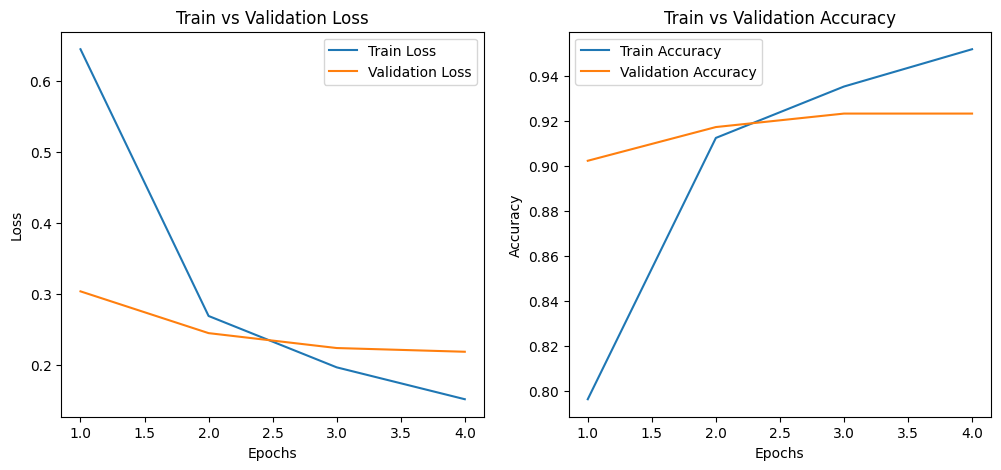

In [13]:
visualize_training_results(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, dataloader, class_names, num_images):
    """
    Функція для візуалізації передбачень моделі.
    
    Параметри:
    - model: модель для передбачень
    - dataloader: dataloader для тестових чи валідаційних даних
    - class_names: список імен класів для декодування передбачень
    - num_images: кількість зображень для візуалізації
    """
    model.eval()  # Перевести модель в режим оцінки
    images_so_far = 0
    rows = (num_images // 2) + (num_images % 2)  # Розраховуємо кількість рядків для сітки
    fig = plt.figure(figsize=(12, 3 * rows))  # Збільшено висоту фігури для кращої візуалізації

    with torch.no_grad():  # Вимкнути градієнти для валідації
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Переміщуємо на GPU, якщо є

            outputs = model(inputs)  # Отримуємо передбачення
            _, preds = torch.max(outputs, 1)  # Отримуємо передбачений клас для кожного зображення

            for i in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(rows, 2, images_so_far)  # Налаштовуємо підписи для сітки
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[i]]} / True: {class_names[labels[i]]}')

                # Перетворення тензора в зображення для відображення
                img = inputs.cpu().data[i].numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return  # Вивести тільки задану кількість зображень



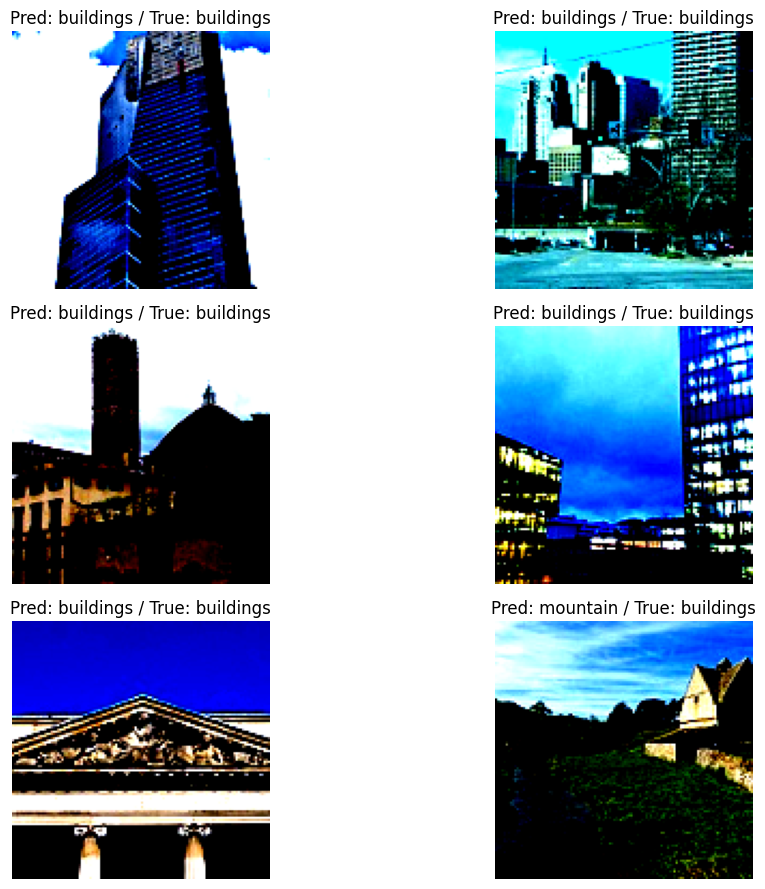

In [15]:
# Приклад виклику
visualize_predictions(model_ft, test_loader, train_dataset.classes, num_images=6)
